In [1]:
import time
import random
import hdbscan
import numpy as np
import pandas as pd
import sklearn.datasets
from sklearn import metrics
from classix import CLASSIX
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.metrics.cluster import v_measure_score
from sklearn import preprocessing
from tqdm import tqdm
from sklearn.cluster import MeanShift
from quickshift.QuickshiftPP import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
plt.style.use('bmh')
seed = 0

np.random.seed(seed)
random.seed(seed)


def test_kmeanspp_labels(X=None, y=None, _range=np.arange(2, 21, 1)):
    ar = list()
    am = list()
    fm = list()
    vm = list()
    
    for i in _range:
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=1)
        kmeans.fit(X)
        ri = metrics.adjusted_rand_score(y, kmeans.labels_)
        mi = metrics.adjusted_mutual_info_score(y, kmeans.labels_)
        f = fowlkes_mallows_score(y, kmeans.labels_)
        v = v_measure_score(y, kmeans.labels_)
        ar.append(ri)
        am.append(mi)
        fm.append(f)
        vm.append(v)
        
    return ar, am, fm, vm


def test_meanshift_labels(X=None, y=None, _range=np.arange(2, 21, 1)):
    ar = list()
    am = list()
    fm = list()
    vm = list()
    
    for i in _range:
        meanshift = MeanShift(bandwidth=i)
        meanshift.fit(X)
        ri = metrics.adjusted_rand_score(y, meanshift.labels_)
        mi = metrics.adjusted_mutual_info_score(y, meanshift.labels_)
        f = fowlkes_mallows_score(y, meanshift.labels_)
        v = v_measure_score(y, meanshift.labels_)
        ar.append(ri)
        am.append(mi)
        fm.append(f)
        vm.append(v)
    return ar, am, fm, vm


def test_dbscan_labels(X=None, y=None, _range=np.arange(0.05, 0.505, 0.005), minPts=5):
    ar = list()
    am = list()
    fm = list()
    vm = list()
    
    for i in _range:
        dbscan = DBSCAN(eps=i, n_jobs=1, min_samples=minPts)
        
        dbscan.fit(X)
        ri = metrics.adjusted_rand_score(y, dbscan.labels_)
        mi = metrics.adjusted_mutual_info_score(y, dbscan.labels_)
        f = fowlkes_mallows_score(y, dbscan.labels_)
        v = v_measure_score(y, dbscan.labels_)
        ar.append(ri)
        am.append(mi)
        fm.append(f)
        vm.append(v)
    return ar, am, fm, vm


def test_hdbscan_labels(X=None, y=None, _range=np.arange(2, 21, 1)):
    ar = list()
    am = list()
    fm = list()
    vm = list()
    
    for i in _range:
        _hdbscan = hdbscan.HDBSCAN(min_cluster_size=int(i), algorithm='best')
        
        _hdbscan.fit(X)
        ri = metrics.adjusted_rand_score(y, _hdbscan.labels_)
        mi = metrics.adjusted_mutual_info_score(y, _hdbscan.labels_)
        f = fowlkes_mallows_score(y, _hdbscan.labels_)
        v = v_measure_score(y, _hdbscan.labels_)
        ar.append(ri)
        am.append(mi)
        fm.append(f)
        vm.append(v)
    return ar, am, fm, vm


def test_quickshiftpp_labels(X=None, y=None, _range=np.arange(2, 17, 1), beta=0.3):
    ar = list()
    am = list()
    fm = list()
    vm = list()
    
    for i in _range:
        quicks = QuickshiftPP(k=i, beta=beta)
        quicks.fit(X.copy(order='C'))
        ri = metrics.adjusted_rand_score(y, quicks.memberships)
        mi = metrics.adjusted_mutual_info_score(y, quicks.memberships)
        f = fowlkes_mallows_score(y, quicks.memberships)
        v = v_measure_score(y, quicks.memberships)
        ar.append(ri)
        am.append(mi)
        fm.append(f)
        vm.append(v)
        
    return ar, am, fm, vm


def test_classix_radius_labels(X=None, y=None, method=None, minPts=1, sorting='pca', _range=np.arange(0.05, 0.3, 0.005)):
    ar = list()
    am = list()
    fm = list()
    vm = list()
    
    for i in _range:
        classix = CLASSIX(radius=i, minPts=minPts, post_alloc=True, sorting=sorting,
            group_merging=method, verbose=0)
        classix.fit(X)
        ri = metrics.adjusted_rand_score(y, classix.labels_)
        mi = metrics.adjusted_mutual_info_score(y, classix.labels_)
        f = fowlkes_mallows_score(y, classix.labels_)
        v = v_measure_score(y, classix.labels_)
        ar.append(ri)
        am.append(mi)
        fm.append(f)
        vm.append(v)
        
    return ar, am, fm, vm


def run_sensitivity_test(datasets, _range, clustering='CLASSIX (Density)', fix_k=1, sorting='pca', label_files=None):
    np.random.seed(1)
    
    X, y = datasets[0], datasets[1]
    nonans = np.isnan(X).sum(1) == 0
    X = X[nonans,:]
    y = y[nonans]
    X = (X - X.mean(axis=0)) / X.std(axis=0)

    if clustering == 'CLASSIX (density)':
        ari, ami, fm, vm = test_classix_radius_labels(X=X, y=y, method='density', minPts=fix_k, sorting=sorting, _range=_range)
    elif clustering == 'CLASSIX (distance)':
        ari, ami, fm, vm = test_classix_radius_labels(X=X, y=y, method='distance', minPts=fix_k, sorting=sorting, _range=_range)
    elif clustering == 'HDBSCAN':
        ari, ami, fm, vm = test_hdbscan_labels(X=X, y=y, _range=_range)
    elif clustering == 'DBSCAN':
        ari, ami, fm, vm = test_dbscan_labels(X=X, y=y, _range=_range, minPts=fix_k)
    elif clustering == 'Quickshift++':
        ari, ami, fm, vm = test_quickshiftpp_labels(X=X, y=y, _range=_range, beta=fix_k)
    elif clustering == 'k-means++':
        ari, ami, fm, vm = test_kmeanspp_labels(X=X, y=y, _range=_range)
    elif clustering == 'Meanshift':
        ari, ami, fm, vm = test_meanshift_labels(X=X, y=y, _range=_range)
    else:
        raise ValueError('Specify a concrete clustering algorithms.')

    store_df = pd.DataFrame()
    store_df['Range'] = _range
    store_df['ARI'] = ari
    store_df['AMI'] = ami
    store_df['FMI'] = fm
    store_df['VM'] = vm
    store_df.to_csv('results/exp5/{}'.format(label_files)+clustering+'.csv', index=False)
    
    
    
    
    
def visualize_params(_range, clustering='CLASSIX (Density)', label_files=None, band=0.01, fig_interval=1):
    # sns.set(font_scale=5)
    store_df = pd.read_csv('results/exp5/{}'.format(label_files)+clustering+'.csv')
    _range = store_df['Range'].values
    ami = store_df['AMI'].values
    ari = store_df['ARI'].values
    
    plt.figure(figsize=(6, 3.6))
    plt.rcParams['axes.facecolor'] = 'white'
    # plt.rc('font', family='serif')
    plt.plot(_range, ari, label='ARI',
             marker='o', markersize=10, c='red')  

    plt.plot(_range, ami, label='AMI',
             marker='*', markersize=8, c='darkorange')

    plt.legend(fontsize=32, fancybox=True, loc='best')
    plt.ylim(-.05, 1.05)
    # plt.xticks(np.arange(min(_range), max(_range)+1, fig_interval))
    plt.xticks([min(_range), max(_range)])
    plt.yticks([0, 0.5, 1])
    plt.xlim(-band+min(_range), band+max(_range))
   
    plt.tick_params(axis='both',  labelsize=32)

    plt.savefig('results/exp5/{}'.format(label_files)+clustering+'.pdf', bbox_inches='tight')
    # plt.show()  
    
    
    
    
    
def params_search():
    datasets = []

    data = pd.read_csv('data/Real_data/Banknote_authentication.csv')
    X_banknote = data.drop(['4'],axis=1).values
    y_banknote = data['4'].values
    # print("Shape of banknote data: ", data.shape, ", labels: ", len(set(y_banknote)))
    datasets.append((X_banknote, y_banknote))

    data = pd.read_csv("data/Real_data/Dermatology.csv").values
    X_dermatology = data[:, :data.shape[1]-1]
    y_dermatology = data[:, data.shape[1]-1]
    # print("Shape of Dermatology data: ", data.shape, ", labels: ", len(set(y_dermatology)))
    datasets.append((X_dermatology, y_dermatology))

    data = pd.read_csv("data/Real_data/Ecoli.csv").values
    X_ecoli = data[:, range(data.shape[1] - 1)]
    y_ecoli = data[:, data.shape[1] - 1]
    # print("Shape of Ecoli data: ", data.shape, ", labels: ", len(set(y_ecoli)))
    datasets.append((X_ecoli,y_ecoli))

    data = pd.read_csv("data/Real_data/Glass.csv")
    le = preprocessing.LabelEncoder()
    data['Glass'] = le.fit_transform(data['Glass'])
    X_glass = data.drop(['Glass', 'Id'],axis=1).values
    y_glass = data['Glass'].values
    # print("Shape of Glass data: ", data.shape, ", labels: ", len(set(y_glass)))
    datasets.append((X_glass, y_glass))

    data = pd.read_csv("data/Real_data/Iris.csv")
    le = preprocessing.LabelEncoder()
    data['Species'] = le.fit_transform(data['Species'])
    X_irirs = data.drop(['Species','Id'],axis=1).values
    y_irirs = data['Species'].values
    # print("Shape of Iris data: ", data.shape, ", labels: ", len(set(y_irirs)))
    datasets.append((X_irirs,y_irirs))
    
    data = pd.read_csv("data/Real_data/Phoneme.csv")
    le = preprocessing.LabelEncoder()
    data['g'] = le.fit_transform(data['g'])
    X_phoneme = data.drop(['speaker', 'g'],axis=1).values
    y_phoneme = data['g'].values
    # print("Shape of Phoneme data: ", data.shape, ", labels: ", len(set(y_phoneme)))
    datasets.append((X_phoneme, y_phoneme))

    data = pd.read_csv('data/Real_data/Seeds.csv')
    X_seeds = data.drop(['7'],axis=1).values
    y_seeds = data['7'].values
    # print("Shape of seeds data: ", data.shape, ", labels: ", len(set(y_seeds)))
    datasets.append((X_seeds, y_seeds))
    
    data = pd.read_csv("data/Real_data/Wine.csv")
    X_wine = data.drop(['14'],axis=1).values
    y_wine = data['14'].values
    # print("Shape of Wine data: ", data.shape, ", labels: ", len(set(y_wine)))
    datasets.append((X_wine, y_wine))
    
    # ==========================================================================
    # ****************************************************************Mean shift
    fig_interval = 2
    band = 0.5

    _range = np.arange(1, 16, 1)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[0], _range=_range, clustering='Meanshift', 
                         label_files='Banknote')

    _range = np.arange(1, 16, 1)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[1], _range=_range, clustering='Meanshift',  
                         label_files='Dermatology')

    _range = np.arange(1, 16, 1)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[2], _range=_range, clustering='Meanshift', 
                         label_files='Ecoli')

    _range = np.arange(1, 16, 1)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[3], _range=_range, clustering='Meanshift', 
                         label_files='Glass')

    _range = np.arange(1, 16, 1)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[4], _range=_range, clustering='Meanshift', 
                         label_files='Iris')

    _range = np.arange(5, 20, 1)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[5], _range=_range, clustering='Meanshift', 
                         label_files='Phoneme')

    _range = np.arange(1, 16, 1)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[6], _range=_range, clustering='Meanshift',
                         label_files='WheatSeeds')

    _range = np.arange(1, 16, 1)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[7], _range=_range, clustering='Meanshift', 
                         label_files='Wine')

    # ==========================================================================
    # ****************************************************************DBSCAN
    fig_interval = 0.1
    band = 0.01
    
    _range = np.arange(0.15, 0.525, 0.025)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[0], _range=_range, clustering='DBSCAN', fix_k=5, 
                         label_files='Banknote')

    _range = np.arange(5.15, 5.525, 0.025)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[1], _range=_range, clustering='DBSCAN', fix_k=5, 
                         label_files='Dermatology')

    _range = np.arange(0.55, 0.925, 0.025)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[2], _range=_range, clustering='DBSCAN', fix_k=5,
                         label_files='Ecoli')

    _range = np.arange(1.55, 1.925, 0.025)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[3], _range=_range, clustering='DBSCAN', fix_k=5, 
                         label_files='Glass')

    _range = np.arange(0.55, 0.925, 0.025)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[4], _range=_range, clustering='DBSCAN', fix_k=5, 
                         label_files='Iris')

    _range = np.arange(9, 9.375, 0.025)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[5], _range=_range, clustering='DBSCAN', fix_k=10, 
                         label_files='Phoneme')

    _range = np.arange(0.55, 0.925, 0.025)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[6], _range=_range, clustering='DBSCAN', fix_k=5, 
                         label_files='WheatSeeds')
    
    _range = np.arange(2.2, 2.575, 0.025)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[7], _range=_range, clustering='DBSCAN', fix_k=5, 
                         label_files='Wine')

    
    # ==========================================================================
    # ****************************************************************HDBSCAN
    fig_interval = 2
    band = 0.5
    
    _range = np.arange(5, 20, 1)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[0], _range=_range, clustering='HDBSCAN', 
                         label_files='Banknote')
    
    _range = np.arange(2, 17, 1)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[1], _range=_range, clustering='HDBSCAN', 
                         label_files='Dermatology')

    _range = np.arange(2, 17, 1)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[2], _range=_range, clustering='HDBSCAN', 
                         label_files='Ecoli')

    _range = np.arange(2, 17, 1)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[3], _range=_range, clustering='HDBSCAN', 
                         label_files='Glass')

    _range = np.arange(2, 17, 1)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[4], _range=_range, clustering='HDBSCAN', 
                         label_files='Iris')

    _range = np.arange(2, 17, 1)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[5], _range=_range, clustering='HDBSCAN',
                         label_files='Phoneme')

    _range = np.arange(2, 17, 1)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[6], _range=_range, clustering='HDBSCAN', 
                         label_files='WheatSeeds')


    _range = np.arange(2, 17, 1)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[7], _range=_range, clustering='HDBSCAN', 
                         label_files='Wine')

    
    # ==========================================================================
    # ****************************************************************Quickshift++
    fig_interval = 2
    band = 0.5

    _range = np.arange(10, 25, 1)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[0], _range=_range, clustering='Quickshift++', fix_k=0.7,
                         label_files='Banknote')
    

    _range = np.arange(7, 22, 1)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[1], _range=_range, clustering='Quickshift++', fix_k=0.3, 
                         label_files='Dermatology')

    _range = np.arange(5, 20, 1)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[2], _range=_range, clustering='Quickshift++', fix_k=0.3, 
                         label_files='Ecoli')

    _range = np.arange(5, 20, 1)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[3], _range=_range, clustering='Quickshift++', fix_k=0.3, 
                         label_files='Glass')

    _range = np.arange(10, 25, 1)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[4], _range=_range, clustering='Quickshift++', fix_k=0.3, 
                         label_files='Iris')

    _range = np.arange(235, 250, 1)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[5], _range=_range, clustering='Quickshift++', fix_k=0.3, 
                         label_files='Phoneme')
    
    _range = np.arange(10, 25, 1)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[6], _range=_range, clustering='Quickshift++', fix_k=0.3,
                         label_files='WheatSeeds')


    _range = np.arange(5, 20, 1)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[7], _range=_range, clustering='Quickshift++', fix_k=0.3, 
                         label_files='Wine')
    

    # ==========================================================================
    # ****************************************************************CLASSIX distance
    fig_interval = 0.1
    band = 0.015

    _range = np.arange(0.01, 0.375, 0.025)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[0], _range=_range, clustering='CLASSIX (distance)', fix_k=6, sorting='pca', 
                         label_files='Banknote')


    _range = np.arange(0.325, 0.676, 0.025)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[1], _range=_range, clustering='CLASSIX (distance)', fix_k=4, sorting='pca', 
                         label_files='Dermatology')

    _range = np.arange(0.1, 0.475, 0.025)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[2], _range=_range, clustering='CLASSIX (distance)', fix_k=3, sorting='pca',
                         label_files='Ecoli')

    _range = np.arange(0.375, 0.75, 0.025)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[3], _range=_range, clustering='CLASSIX (distance)', fix_k=0, sorting='pca',
                         label_files='Glass')

    _range = np.arange(0.15, 0.525, 0.025)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[4], _range=_range, clustering='CLASSIX (distance)', fix_k=6, sorting='pca',
                         label_files='Iris')

    _range = np.arange(0.27, 0.625, 0.025)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[5], _range=_range, clustering='CLASSIX (distance)', fix_k=9, sorting='pca',
                         label_files='Phoneme')

    _range = np.arange(0.05, 0.425, 0.025)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[6], _range=_range, clustering='CLASSIX (distance)', fix_k=7, sorting='pca',
                         label_files='WheatSeeds')

    _range = np.arange(0.2, 0.575, 0.025)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[7], _range=_range, clustering='CLASSIX (distance)', fix_k=7, sorting='pca',
                         label_files='Wine')


    # ==========================================================================
    # ****************************************************************CLASSIX density
    fig_interval = 0.1
    band = 0.015

    _range = np.arange(0.05, 0.425, 0.025)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[0], _range=_range, clustering='CLASSIX (density)', fix_k=6, sorting='pca', 
                         label_files='Banknote')

    _range = np.arange(0.5, 0.875, 0.025)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[1], _range=_range, clustering='CLASSIX (density)', fix_k=4, sorting='pca', 
                         label_files='Dermatology')

    _range = np.arange(0.1, 0.475, 0.025)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[2], _range=_range, clustering='CLASSIX (density)', fix_k=3, sorting='pca',
                         label_files='Ecoli')

    _range = np.arange(0.475, 0.85, 0.025)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[3], _range=_range, clustering='CLASSIX (density)', fix_k=0, sorting='pca',
                         label_files='Glass')

    _range = np.arange(0.15, 0.525, 0.025)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[4], _range=_range, clustering='CLASSIX (density)', fix_k=6, sorting='pca',
                         label_files='Iris')

    _range = np.arange(1.3, 1.675, 0.025)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[5], _range=_range, clustering='CLASSIX (density)', fix_k=9, sorting='pca',
                         label_files='Phoneme')

    _range = np.arange(0.1, 0.475, 0.025)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[6], _range=_range, clustering='CLASSIX (density)', fix_k=7, sorting='pca',
                         label_files='WheatSeeds')

    _range = np.arange(0.4, 0.775, 0.025)
    # print("Parameter range: ", len(_range))
    run_sensitivity_test(datasets=datasets[7], _range=_range, clustering='CLASSIX (density)', fix_k=7, sorting='pca',
                         label_files='Wine')

    
    
def visualize_params_search():
    # ==========================================================================
    # ****************************************************************Mean shift
    fig_interval = 2
    band = 0.5
    
    _range = np.arange(1, 16, 1)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='Meanshift', 
                         label_files='Banknote', band=band, fig_interval=fig_interval)
    
    _range = np.arange(1, 16, 1)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='Meanshift',  
                         label_files='Dermatology', band=band, fig_interval=fig_interval)

    _range = np.arange(1, 16, 1)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='Meanshift', 
                         label_files='Ecoli', band=band, fig_interval=fig_interval)

    _range = np.arange(1, 16, 1)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='Meanshift', 
                         label_files='Glass', band=band, fig_interval=fig_interval)

    _range = np.arange(1, 16, 1)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='Meanshift', 
                         label_files='Iris', band=band, fig_interval=fig_interval)

    _range = np.arange(5, 20, 1)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='Meanshift', 
                         label_files='Phoneme', band=band, fig_interval=fig_interval)

    _range = np.arange(1, 16, 1)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='Meanshift',
                         label_files='WheatSeeds', band=band, fig_interval=fig_interval)

    _range = np.arange(1, 16, 1)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='Meanshift', 
                         label_files='Wine', band=band, fig_interval=fig_interval)

    # ==========================================================================
    # ****************************************************************DBSCAN
    fig_interval = 0.1
    band = 0.01
    
    _range = np.arange(0.15, 0.525, 0.025)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='DBSCAN', 
                         label_files='Banknote', band=band, fig_interval=fig_interval)
   
    _range = np.arange(5.15, 5.525, 0.025)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='DBSCAN',  
                         label_files='Dermatology', band=band, fig_interval=fig_interval)

    _range = np.arange(0.55, 0.925, 0.025)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='DBSCAN', 
                         label_files='Ecoli', band=band, fig_interval=fig_interval)

    _range = np.arange(1.55, 1.925, 0.025)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='DBSCAN', 
                         label_files='Glass', band=band, fig_interval=fig_interval)

    _range = np.arange(0.55, 0.925, 0.025)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='DBSCAN', 
                         label_files='Iris', band=band, fig_interval=fig_interval)

    _range = np.arange(9, 9.375, 0.025)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='DBSCAN', 
                         label_files='Phoneme', band=band, fig_interval=fig_interval)

    _range = np.arange(0.55, 0.925, 0.025)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='DBSCAN', 
                         label_files='WheatSeeds', band=band, fig_interval=fig_interval)

    _range = np.arange(2.2, 2.575, 0.025)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='DBSCAN', 
                         label_files='Wine', band=band, fig_interval=fig_interval)

    
    # ==========================================================================
    # ****************************************************************HDBSCAN
    fig_interval = 2
    band = 0.5
    
    _range = np.arange(5, 20, 1)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='HDBSCAN', 
                         label_files='Banknote', band=band, fig_interval=fig_interval)
    
    _range = np.arange(2, 17, 1)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='HDBSCAN', 
                         label_files='Dermatology', band=band, fig_interval=fig_interval)

    _range = np.arange(2, 17, 1)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='HDBSCAN', 
                         label_files='Ecoli', band=band, fig_interval=fig_interval)

    _range = np.arange(2, 17, 1)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='HDBSCAN', 
                         label_files='Glass', band=band, fig_interval=fig_interval)

    _range = np.arange(2, 17, 1)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='HDBSCAN', 
                         label_files='Iris', band=band, fig_interval=fig_interval)
    
    _range = np.arange(2, 17, 1)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='HDBSCAN',
                         label_files='Phoneme', band=band, fig_interval=fig_interval)

    _range = np.arange(2, 17, 1)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='HDBSCAN', 
                         label_files='WheatSeeds', band=band, fig_interval=fig_interval)

    _range = np.arange(2, 17, 1)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='HDBSCAN', 
                         label_files='Wine', band=band, fig_interval=fig_interval)

    
    # ==========================================================================
    # ****************************************************************Quickshift++
    fig_interval = 2
    band = 0.5

    _range = np.arange(10, 25, 1)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='Quickshift++',
                         label_files='Banknote', band=band, fig_interval=fig_interval)
    
    _range = np.arange(7, 22, 1)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='Quickshift++', 
                         label_files='Dermatology', band=band, fig_interval=fig_interval)

    _range = np.arange(5, 20, 1)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='Quickshift++', 
                         label_files='Ecoli', band=band, fig_interval=fig_interval)

    _range = np.arange(5, 20, 1)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='Quickshift++', 
                         label_files='Glass', band=band, fig_interval=fig_interval)

    _range = np.arange(10, 25, 1)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='Quickshift++',
                         label_files='Iris', band=band, fig_interval=fig_interval)

    _range = np.arange(235, 250, 1)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='Quickshift++', 
                         label_files='Phoneme', band=band, fig_interval=fig_interval+5)
    
    _range = np.arange(10, 25, 1)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='Quickshift++', 
                         label_files='WheatSeeds', band=band, fig_interval=fig_interval)

    _range = np.arange(5, 20, 1)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='Quickshift++',
                         label_files='Wine', band=band, fig_interval=fig_interval)
    
    # ==========================================================================
    # ****************************************************************CLASSIX distance
    fig_interval = 0.1
    band = 0.015

    _range = np.arange(0.01, 0.375, 0.025)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='CLASSIX (distance)',  
                         label_files='Banknote', band=band, fig_interval=fig_interval)

    _range = np.arange(0.325, 0.676, 0.025)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='CLASSIX (distance)', 
                         label_files='Dermatology', band=band, fig_interval=fig_interval)

    _range = np.arange(0.1, 0.475, 0.025)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='CLASSIX (distance)', 
                         label_files='Ecoli', band=band, fig_interval=fig_interval)

    _range = np.arange(0.375, 0.75, 0.025)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='CLASSIX (distance)',
                         label_files='Glass', band=band, fig_interval=fig_interval)

    _range = np.arange(0.15, 0.525, 0.025)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='CLASSIX (distance)',
                         label_files='Iris', band=band, fig_interval=fig_interval)

    _range = np.arange(0.27, 0.625, 0.025)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='CLASSIX (distance)', 
                         label_files='Phoneme', band=band, fig_interval=fig_interval)

    _range = np.arange(0.05, 0.425, 0.025)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='CLASSIX (distance)', 
                         label_files='WheatSeeds', band=band, fig_interval=fig_interval)

    _range = np.arange(0.2, 0.575, 0.025)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='CLASSIX (distance)', 
                         label_files='Wine', band=band, fig_interval=fig_interval)


    # ==========================================================================
    # ****************************************************************CLASSIX density
    fig_interval = 0.1
    band = 0.015
    
    _range = np.arange(0.05, 0.425, 0.025)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='CLASSIX (density)',  
                         label_files='Banknote', band=band, fig_interval=fig_interval)

    _range = np.arange(0.5, 0.875, 0.025)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='CLASSIX (density)', 
                         label_files='Dermatology', band=band, fig_interval=fig_interval)

    _range = np.arange(0.1, 0.475, 0.025)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='CLASSIX (density)', 
                         label_files='Ecoli', band=band, fig_interval=fig_interval)

    _range = np.arange(0.475, 0.85, 0.025)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='CLASSIX (density)',
                         label_files='Glass', band=band, fig_interval=fig_interval)

    _range = np.arange(0.15, 0.525, 0.025)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='CLASSIX (density)',
                         label_files='Iris', band=band, fig_interval=fig_interval)

    _range = np.arange(1.3, 1.675, 0.025)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='CLASSIX (density)', 
                         label_files='Phoneme', band=band, fig_interval=fig_interval)

    _range = np.arange(0.1, 0.475, 0.025)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='CLASSIX (density)', 
                         label_files='WheatSeeds', band=band, fig_interval=fig_interval)


    _range = np.arange(0.4, 0.775, 0.025)
    # print("Parameter range: ", len(_range))
    visualize_params(_range=_range, clustering='CLASSIX (density)', 
                         label_files='Wine', band=band, fig_interval=fig_interval)


    
def compare_best_params():
    datasets = []
    
    data = pd.read_csv("data/Real_data/Iris.csv")
    le = preprocessing.LabelEncoder()
    
    data['Species'] = le.fit_transform(data['Species'])
    X_irirs = data.drop(['Species','Id'],axis=1).values
    y_irirs = data['Species'].values
    datasets.append((X_irirs, y_irirs))

    data = pd.read_csv("data/Real_data/Dermatology.csv").values
    X_dermatology = data[:, :data.shape[1]-1]
    y_dermatology = data[:, data.shape[1]-1]
    datasets.append((X_dermatology, y_dermatology))

    data = pd.read_csv("data/Real_data/Ecoli.csv").values
    X_ecoli = data[:, range(data.shape[1] - 1)]
    y_ecoli = data[:, data.shape[1] - 1]
    datasets.append((X_ecoli, y_ecoli))

    data = pd.read_csv("data/Real_data/Glass.csv")
    le = preprocessing.LabelEncoder()
    data['Glass'] = le.fit_transform(data['Glass'])
    X_glass = data.drop(['Glass', 'Id'],axis=1).values
    y_glass = data['Glass'].values
    datasets.append((X_glass, y_glass))

    data = pd.read_csv("data/Real_data/Banknote_authentication.csv")
    X_banknote = data.drop(['4'],axis=1).values
    y_banknote = data['4'].values
    datasets.append((X_banknote, y_banknote))

    data = pd.read_csv("data/Real_data/Seeds.csv")
    X_seeds = data.drop(['7'],axis=1).values
    y_seeds = data['7'].values
    datasets.append((X_seeds, y_seeds))

    data = pd.read_csv("data/Real_data/Phoneme.csv")
    le = preprocessing.LabelEncoder()
    data['g'] = le.fit_transform(data['g'])
    X_phoneme = data.drop(['speaker', 'g'],axis=1).values
    y_phoneme = data['g'].values
    datasets.append((X_phoneme, y_phoneme))


    data = pd.read_csv("data/Real_data/Wine.csv")
    X_wine = data.drop(['14'],axis=1).values
    y_wine = data['14'].values
    datasets.append((X_wine, y_wine))

    clean_datasets = []

    x_Banknote, y_Banknote = datasets[4][0], datasets[4][1] # Banknote
    nonans = np.isnan(x_Banknote).sum(1) == 0
    x_Banknote = x_Banknote[nonans,:]
    y_Banknote = y_Banknote[nonans]
    x_Banknote = (x_Banknote - x_Banknote.mean(axis=0)) / x_Banknote.std(axis=0)
    clean_datasets.append((x_Banknote, y_Banknote))

    x_Dermatology, y_Dermatology = datasets[1][0], datasets[1][1] # Dermatology
    nonans = np.isnan(x_Dermatology).sum(1) == 0
    x_Dermatology = x_Dermatology[nonans,:]
    y_Dermatology = y_Dermatology[nonans]
    x_Dermatology = (x_Dermatology - x_Dermatology.mean(axis=0)) / x_Dermatology.std(axis=0)
    clean_datasets.append((x_Dermatology, y_Dermatology))

    x_Ecoli, y_Ecoli = datasets[2][0], datasets[2][1] # Ecoli
    nonans = np.isnan(x_Ecoli).sum(1) == 0
    x_Ecoli = x_Ecoli[nonans,:]
    y_Ecoli = y_Ecoli[nonans]
    x_Ecoli = (x_Ecoli - x_Ecoli.mean(axis=0)) / x_Ecoli.std(axis=0)
    clean_datasets.append((x_Ecoli, y_Ecoli))

    x_Glass, y_Glass = datasets[3][0], datasets[3][1] # Glass
    nonans = np.isnan(x_Glass).sum(1) == 0
    x_Glass = x_Glass[nonans,:]
    y_Glass = y_Glass[nonans]
    x_Glass = (x_Glass - x_Glass.mean(axis=0)) / x_Glass.std(axis=0)
    clean_datasets.append((x_Glass, y_Glass))

    x_Iris, y_Iris = datasets[0][0], datasets[0][1] # Iris
    nonans = np.isnan(x_Iris).sum(1) == 0
    x_Iris = x_Iris[nonans,:]
    y_Iris = y_Iris[nonans]
    x_Iris = (x_Iris - x_Iris.mean(axis=0)) / x_Iris.std(axis=0)
    clean_datasets.append((x_Iris, y_Iris))

    x_Phoneme, y_Phoneme = datasets[6][0], datasets[6][1] # Seeds
    nonans = np.isnan(x_Phoneme).sum(1) == 0
    x_Phoneme = x_Phoneme[nonans,:]
    y_Phoneme = y_Phoneme[nonans]
    x_Phoneme = (x_Phoneme - x_Phoneme.mean(axis=0)) / x_Phoneme.std(axis=0)
    clean_datasets.append((x_Phoneme, y_Phoneme))

    x_Seeds, y_Seeds = datasets[5][0], datasets[5][1] # Seeds
    nonans = np.isnan(x_Seeds).sum(1) == 0
    x_Seeds = x_Seeds[nonans,:]
    y_Seeds = y_Seeds[nonans]
    x_Seeds = (x_Seeds - x_Seeds.mean(axis=0)) / x_Seeds.std(axis=0)
    clean_datasets.append((x_Seeds, y_Seeds))

    x_Wine, y_Wine = datasets[7][0], datasets[7][1] # Seeds
    nonans = np.isnan(x_Wine).sum(1) == 0
    x_Wine = x_Wine[nonans,:]
    y_Wine = y_Wine[nonans]
    x_Wine = (x_Wine - x_Wine.mean(axis=0)) / x_Wine.std(axis=0)
    clean_datasets.append((x_Wine, y_Wine))

    
    meanshift_params = {"Banknote":{'bandwidth':1},
                        "Dermatology":{'bandwidth':5},
                        "Ecoli":{'bandwidth':2},
                        "Glass":{'bandwidth':2},
                        "Iris":{'bandwidth':2},
                        "Phoneme":{'bandwidth':12},
                        "Seeds":{'bandwidth':2},
                        "Wine":{'bandwidth':3}
                        }

    dname = list(meanshift_params.keys())
    meanshift_mi = list()
    meanshift_ri = list()
    meanshift_fm = list()
    meanshift_vm = list()
    
    for i, dataset in enumerate(clean_datasets):
        X, y = dataset[0], dataset[1]
        np.random.seed(1)
        meanshift = MeanShift(**meanshift_params[dname[i]])
        st = time.time()
        meanshift.fit(X)
        ami = metrics.adjusted_mutual_info_score(y.astype(int), meanshift.labels_.astype(int))
        ari = metrics.adjusted_rand_score(y.astype(int), meanshift.labels_.astype(int))
        fm = fowlkes_mallows_score(y.astype(int), meanshift.labels_.astype(int))
        vm = v_measure_score(y.astype(int), meanshift.labels_.astype(int))
        
        meanshift_mi.append(ami)
        meanshift_ri.append(ari)
        meanshift_fm.append(fm)
        meanshift_vm.append(vm)
        
    dbscan_params = {"Banknote":{'eps':0.475, 'min_samples':5},
                     "Dermatology":{'eps':5.275, 'min_samples':5},
                     "Ecoli":{'eps':0.875, 'min_samples':5},
                     "Glass":{'eps':1.7, 'min_samples':5},                      
                     "Iris":{'eps':0.8, 'min_samples':5},
                     "Phoneme":{'eps':9.175, 'min_samples':10},
                     "Seeds":{'eps':0.875, 'min_samples':5},
                     "Wine":{'eps':2.425, 'min_samples':5},
                    }

    dname = list(dbscan_params.keys())
    dbscan_mi = list()
    dbscan_ri = list()
    dbscan_fm = list()
    dbscan_vm = list()
    
    for i, dataset in enumerate(clean_datasets):
        X, y = dataset[0], dataset[1]
        np.random.seed(1)
        dbscan = DBSCAN(**dbscan_params[dname[i]])
        st = time.time()
        dbscan.fit(X)
        ami = metrics.adjusted_mutual_info_score(y.astype(int), dbscan.labels_.astype(int))
        ari = metrics.adjusted_rand_score(y.astype(int), dbscan.labels_.astype(int))
        fm = fowlkes_mallows_score(y.astype(int), dbscan.labels_.astype(int))
        vm = v_measure_score(y.astype(int), dbscan.labels_.astype(int))
        
        dbscan_mi.append(ami)
        dbscan_ri.append(ari)
        dbscan_fm.append(fm)
        dbscan_vm.append(vm)

    hdbscan_params = {"Banknote":{'min_cluster_size':16},
                      "Dermatology":{'min_cluster_size':5},
                      "Ecoli":{'min_cluster_size':9},
                      "Glass":{'min_cluster_size':8},
                      "Iris":{'min_cluster_size':9},
                      "Phoneme":{'min_cluster_size':3},
                      "Seeds":{'min_cluster_size':3},
                      "Wine":{'min_cluster_size':3},
                      }

    dname = list(hdbscan_params.keys())
    hdbscan_mi = list()
    hdbscan_ri = list()
    hdbscan_fm = list()
    hdbscan_vm = list()
    
    for i, dataset in enumerate(clean_datasets):
        X, y = dataset[0], dataset[1]
        np.random.seed(1)
        _hdbscan = hdbscan.HDBSCAN(**hdbscan_params[dname[i]])
        st = time.time()
        _hdbscan.fit(X)
        ami = metrics.adjusted_mutual_info_score(y.astype(int), _hdbscan.labels_.astype(int))
        ari = metrics.adjusted_rand_score(y.astype(int), _hdbscan.labels_.astype(int))
        fm = fowlkes_mallows_score(y.astype(int), _hdbscan.labels_.astype(int))
        vm = v_measure_score(y.astype(int), _hdbscan.labels_.astype(int))
        
        hdbscan_mi.append(ami)
        hdbscan_ri.append(ari)
        hdbscan_fm.append(fm)
        hdbscan_vm.append(vm)
        
    quickshiftpp_params = {"Banknote":{'k':20, 'beta':0.7},
                           "Dermatology":{'k':20, 'beta':0.3},
                           "Ecoli":{'k':14, 'beta':0.3},
                           "Glass":{'k':17, 'beta':0.3},
                           "Iris":{'k':18, 'beta':0.3},
                           "Phoneme":{'k':245, 'beta':0.3},
                           "Seeds":{'k':21, 'beta':0.3},
                           "Wine":{'k':16, 'beta':0.3},
                           }

    dname = list(quickshiftpp_params.keys())
    quicks_mi = list()
    quicks_ri = list()
    quicks_fm = list()
    quicks_vm = list()
    
    for i, dataset in enumerate(clean_datasets):
        X, y = dataset[0], dataset[1]
        np.random.seed(1)
        quicks = QuickshiftPP(**quickshiftpp_params[dname[i]])
        st = time.time()
        quicks.fit(X.copy(order='C'))
        ami = metrics.adjusted_mutual_info_score(y.astype(int), quicks.memberships.astype(int))
        ari = metrics.adjusted_rand_score(y.astype(int), quicks.memberships.astype(int))
        fm = fowlkes_mallows_score(y.astype(int), quicks.memberships.astype(int))
        vm = v_measure_score(y.astype(int), quicks.memberships.astype(int))
        
        quicks_mi.append(ami)
        quicks_ri.append(ari)
        quicks_fm.append(fm)
        quicks_vm.append(vm)
        
    clx_dist_params = {"Banknote":{'radius':0.21, 'group_merging':'distance', 'minPts':41, 'verbose':0},
                       "Dermatology":{'radius':0.4, 'group_merging':'distance','minPts':4, 'verbose':0},
                       "Ecoli":{'radius':0.3, 'group_merging':'distance', 'minPts':4, 'verbose':0},
                       "Glass":{'radius':0.725, 'group_merging':'distance', 'minPts':0, 'verbose':0},
                       "Iris":{'radius':0.225, 'group_merging':'distance', 'minPts':4, 'verbose':0},
                       "Phoneme":{'radius':0.445, 'group_merging':'distance', 'minPts':8, 'verbose':0},
                       "Seeds":{'radius':0.15, 'group_merging':'distance', 'minPts':9, 'verbose':0},
                       "Wine":{'radius':0.425, 'group_merging':'distance', 'minPts':4, 'verbose':0}
                       }

    dname = list(clx_dist_params.keys())
    clx_dis_mi = list()
    clx_dis_ri = list()
    clx_dis_fm = list()
    clx_dis_vm = list()
    
    for i, dataset in enumerate(clean_datasets):
        X, y = dataset[0], dataset[1]
        np.random.seed(1)
        clx = CLASSIX(**clx_dist_params[dname[i]])
        st = time.time()
        clx.fit(X)

        ari = metrics.adjusted_rand_score(y.astype(int), clx.labels_.astype(int))
        ami = metrics.adjusted_mutual_info_score(y.astype(int), clx.labels_.astype(int))
        fm = fowlkes_mallows_score(y.astype(int), clx.labels_.astype(int))
        vm = v_measure_score(y.astype(int), clx.labels_.astype(int))
        
        clx_dis_ri.append(ari)
        clx_dis_mi.append(ami)
        clx_dis_fm.append(fm)
        clx_dis_vm.append(vm)
        
    clx_den_params = {"Banknote":{'radius':0.28, 'group_merging':'density', 'minPts':40, 'verbose':0},
                      "Dermatology":{'radius':0.6, 'group_merging':'density','minPts':4, 'verbose':0},
                      "Ecoli":{'radius':0.375, 'group_merging':'density', 'minPts':4, 'verbose':0},
                      "Glass":{'radius':0.62, 'group_merging':'density', 'minPts':0, 'verbose':0},
                      "Iris":{'radius':0.275, 'group_merging':'density', 'minPts':7, 'verbose':0},
                      "Phoneme":{'radius':1.425, 'group_merging':'density', 'minPts':460, 'verbose':0},
                      "Seeds":{'radius':0.25, 'group_merging':'density', 'minPts':7, 'verbose':0},
                      "Wine":{'radius':0.58, 'group_merging':'density', 'minPts':7, 'verbose':0}
                     }

    dname = list(clx_den_params.keys())
    clx_den_mi = list()
    clx_den_ri = list()
    clx_den_fm = list()
    clx_den_vm = list()
    
    for i, dataset in enumerate(clean_datasets):
        X, y = dataset[0], dataset[1]
        np.random.seed(1)
        clx = CLASSIX(**clx_den_params[dname[i]])
        st = time.time()
        clx.fit(X)

        ari = metrics.adjusted_rand_score(y.astype(int), clx.labels_.astype(int))
        ami = metrics.adjusted_mutual_info_score(y.astype(int), clx.labels_.astype(int))
        fm = fowlkes_mallows_score(y.astype(int), clx.labels_.astype(int))
        vm = v_measure_score(y.astype(int), clx.labels_.astype(int))
        
        clx_den_ri.append(ari)
        clx_den_mi.append(ami)
        clx_den_fm.append(fm)
        clx_den_vm.append(vm)

    ri_df = pd.DataFrame()
    mi_df = pd.DataFrame()
    fm_df = pd.DataFrame()
    vm_df = pd.DataFrame()
    
    ri_df['dataset'] = dname
    ri_df['meanshift'] = meanshift_ri
    ri_df['dbscan'] = dbscan_ri
    ri_df['hdbscan'] = hdbscan_ri
    ri_df['quickshift++'] = quicks_ri
    ri_df['classix (dis)'] = clx_dis_ri
    ri_df['classix (den)'] = clx_den_ri

    mi_df['dataset'] = dname
    mi_df['meanshift'] = meanshift_mi
    mi_df['dbscan'] = dbscan_mi
    mi_df['hdbscan'] = hdbscan_mi
    mi_df['quickshift++'] = quicks_mi
    mi_df['classix (dis)'] = clx_dis_mi
    mi_df['classix (den)'] = clx_den_mi
    
    fm_df['dataset'] = dname
    fm_df['meanshift'] = meanshift_fm
    fm_df['dbscan'] = dbscan_fm
    fm_df['hdbscan'] = hdbscan_fm
    fm_df['quickshift++'] = quicks_fm
    fm_df['classix (dis)'] = clx_dis_fm
    fm_df['classix (den)'] = clx_den_fm

    vm_df['dataset'] = dname
    vm_df['meanshift'] = meanshift_vm
    vm_df['dbscan'] = dbscan_vm
    vm_df['hdbscan'] = hdbscan_vm
    vm_df['quickshift++'] = quicks_vm
    vm_df['classix (dis)'] = clx_dis_vm
    vm_df['classix (den)'] = clx_den_vm

    mi_df.to_csv("results/exp5/mi_real_cluster_quality.csv", index=False)
    ri_df.to_csv("results/exp5/ri_real_cluster_quality.csv", index=False)
    fm_df.to_csv("results/exp5/fm_real_cluster_quality.csv", index=False)
    vm_df.to_csv("results/exp5/vm_real_cluster_quality.csv", index=False)
    
    
    
def kamil_industry_test():
    X_pca = pd.read_csv("data/Kamil/PCA_clustering.csv").values
    
    # preprocess data
    final_len = 100000
    outliers_position = np.where(X_pca[:,0] > 7.5)[0]
    no_outliers_position = np.delete(np.arange(0, len(X_pca[:,0])), outliers_position, axis=0)

    outlier_len = len(outliers_position)
    data_no_outliers_length = int(final_len - outlier_len)

    data_outliers = X_pca[outliers_position, :]
    data_no_outliers = np.delete(X_pca, outliers_position, axis=0)

    random_integers = np.arange(0, len(no_outliers_position))
    np.random.shuffle(random_integers)

    data_no_outliers_out = data_no_outliers[random_integers[data_no_outliers_length:],:]
    data_no_outliers =  data_no_outliers[random_integers[:data_no_outliers_length],:]

    X = np.concatenate((data_no_outliers, data_outliers))
    
    sample_size = 10
    kamil_timing = []
    
    sum_time = 0
    for i in range(sample_size):
        st = time.time()
        dbscan = DBSCAN(eps=0.7, min_samples=6)
        dbscan.fit(X)
        et = time.time() 
        sum_time = sum_time + et - st
    kamil_timing.append(sum_time/sample_size)
    # print("Average consume time: ", sum_time/sample_size)
    plt.figure(figsize=(24,10))
    plt.scatter(X[:,0], X[:,1], c=dbscan.labels_, cmap='jet')
    # cbar = plt.colorbar() 
    # cbar.ax.tick_params(labelsize=15) 
    plt.tick_params(axis='both',  labelsize=28)
    plt.savefig('results/exp5/DBSCAN_kamil.png', bbox_inches='tight')
    # plt.show()
    
    sum_time = 0
    for i in range(sample_size):
        st = time.time()
        _hdbscan = hdbscan.HDBSCAN(min_cluster_size=1000, core_dist_n_jobs=1)
        hdbscan_labels = _hdbscan.fit_predict(X)
        et = time.time()
        sum_time = sum_time + et - st
    kamil_timing.append(sum_time/sample_size)
    # print("Average consume time: ", sum_time/sample_size)
    plt.figure(figsize=(24,10))
    plt.scatter(X[:,0], X[:,1], c=hdbscan_labels, cmap='jet')
    # cbar = plt.colorbar() 
    # cbar.ax.tick_params(labelsize=15) 
    plt.tick_params(axis='both',  labelsize=28)
    plt.savefig('results/exp5/HDBSCAN_kamil.png', bbox_inches='tight')
    # plt.show()

    sum_time = 0
    for i in range(sample_size):
        st = time.time()
        quicks = QuickshiftPP(k=800, beta=0.7)
        quicks.fit(X.copy(order='C'))
        quicks_labels = quicks.memberships
        et = time.time()
        sum_time = sum_time + et - st
    kamil_timing.append(sum_time/sample_size)
    # print("Average consume time: ", sum_time/sample_size)
    plt.figure(figsize=(24,10))
    plt.scatter(X[:,0], X[:,1], c=quicks_labels, cmap='jet')
    # cbar = plt.colorbar() 
    # cbar.ax.tick_params(labelsize=15) 
    plt.tick_params(axis='both',  labelsize=28)
    plt.savefig('results/exp5/Quickshiftpp_kamil.png', bbox_inches='tight')
    # plt.show()

    sum_time = 0
    for i in range(sample_size):
        st = time.time()
        clx = CLASSIX(sorting='pca', radius=0.3, verbose=0,  group_merging='distance')
        clx.fit_transform(X)
        et = time.time()
        sum_time = sum_time + et - st
    kamil_timing.append(sum_time/sample_size)
    # print("Average consume time: ", sum_time/sample_size)
    plt.figure(figsize=(24,10))
    plt.scatter(X[:,0], X[:,1], c=clx.labels_, cmap='jet')
    # cbar = plt.colorbar() 
    # cbar.ax.tick_params(labelsize=15) 
    plt.tick_params(axis='both',  labelsize=28)
    plt.savefig('results/exp5/CLASSIX_kamil.png', bbox_inches='tight')
    # plt.show()
    
    kamil_timing = pd.DataFrame(kamil_timing)
    kamil_timing = kamil_timing.T
    kamil_timing.columns = ['DBSCAN', 'HDBSCAN', 'Quickshift++', 'CLASSX']
    kamil_timing.to_csv("results/exp5/kamil_timing.csv", index=False)

In [2]:
params_search()

In [3]:

def visualize_params_global():
    plt.style.use('default')
    datasets = ['Banknote', 'Dermatology', 'Ecoli', 'Glass', 'Iris', 'Phoneme', 'WheatSeeds', 'Wine']
    algorithms = ['Meanshift', 'DBSCAN', 'HDBSCAN', 'Quickshift++', 'CLASSIX (distance)', 'CLASSIX (density)']

    plot_num = 1
    fontsize = 60
    band = [0.5, 0.01, 0.5, 0.5, 0.015, 0.015]

    plt.figure(figsize=(8.5*len(datasets), 9*len(algorithms)))
    for data in datasets:
        i = 0
        for algorithm in algorithms:
            store_df = pd.read_csv('results/exp5/{}'.format(data)+algorithm+'.csv')
            _range = store_df['Range'].values
            ars = store_df['ARI'].values
            ami = store_df['AMI'].values
            fm = store_df['FMI'].values
            vm = store_df['VM'].values

            plt.rcParams['axes.facecolor'] = 'white'
            plt.subplot(len(datasets), len(algorithms), plot_num)
            plt.plot(_range, ars, label='ARI', marker='o', markersize=20, c='red')  
            plt.plot(_range, ami, label='AMI', marker='*', markersize=18, c='darkorange')
            plt.plot(_range, fm, label='FMI', marker='^', linestyle=':', markersize=20, c='plum')  
            plt.plot(_range, vm, label='VM', marker='D', linestyle='--', markersize=18, c='teal')
            
            plt.ylim(-.05, 1.05)
            plt.xticks([min(_range), max(_range)])
            plt.yticks([0.5, 1])
            plt.xlim(-band[i]+min(_range), band[i]+max(_range))
            if plot_num == len(algorithms):
                plt.legend(fontsize=fontsize, ncol=2, bbox_to_anchor=(1, 1.65))
            plt.tick_params(axis='both',  labelsize=fontsize)
            plt.grid(True)
            plt.subplots_adjust(bottom=0.01, left=0.01, right=0.99, top=0.99, wspace=0.15, hspace=0.15)
            plot_num = plot_num + 1
            i = i + 1

    plt.tight_layout()
    plt.savefig('results/exp5/ARI_AMI_PARAMS.pdf', bbox_inches='tight')
    

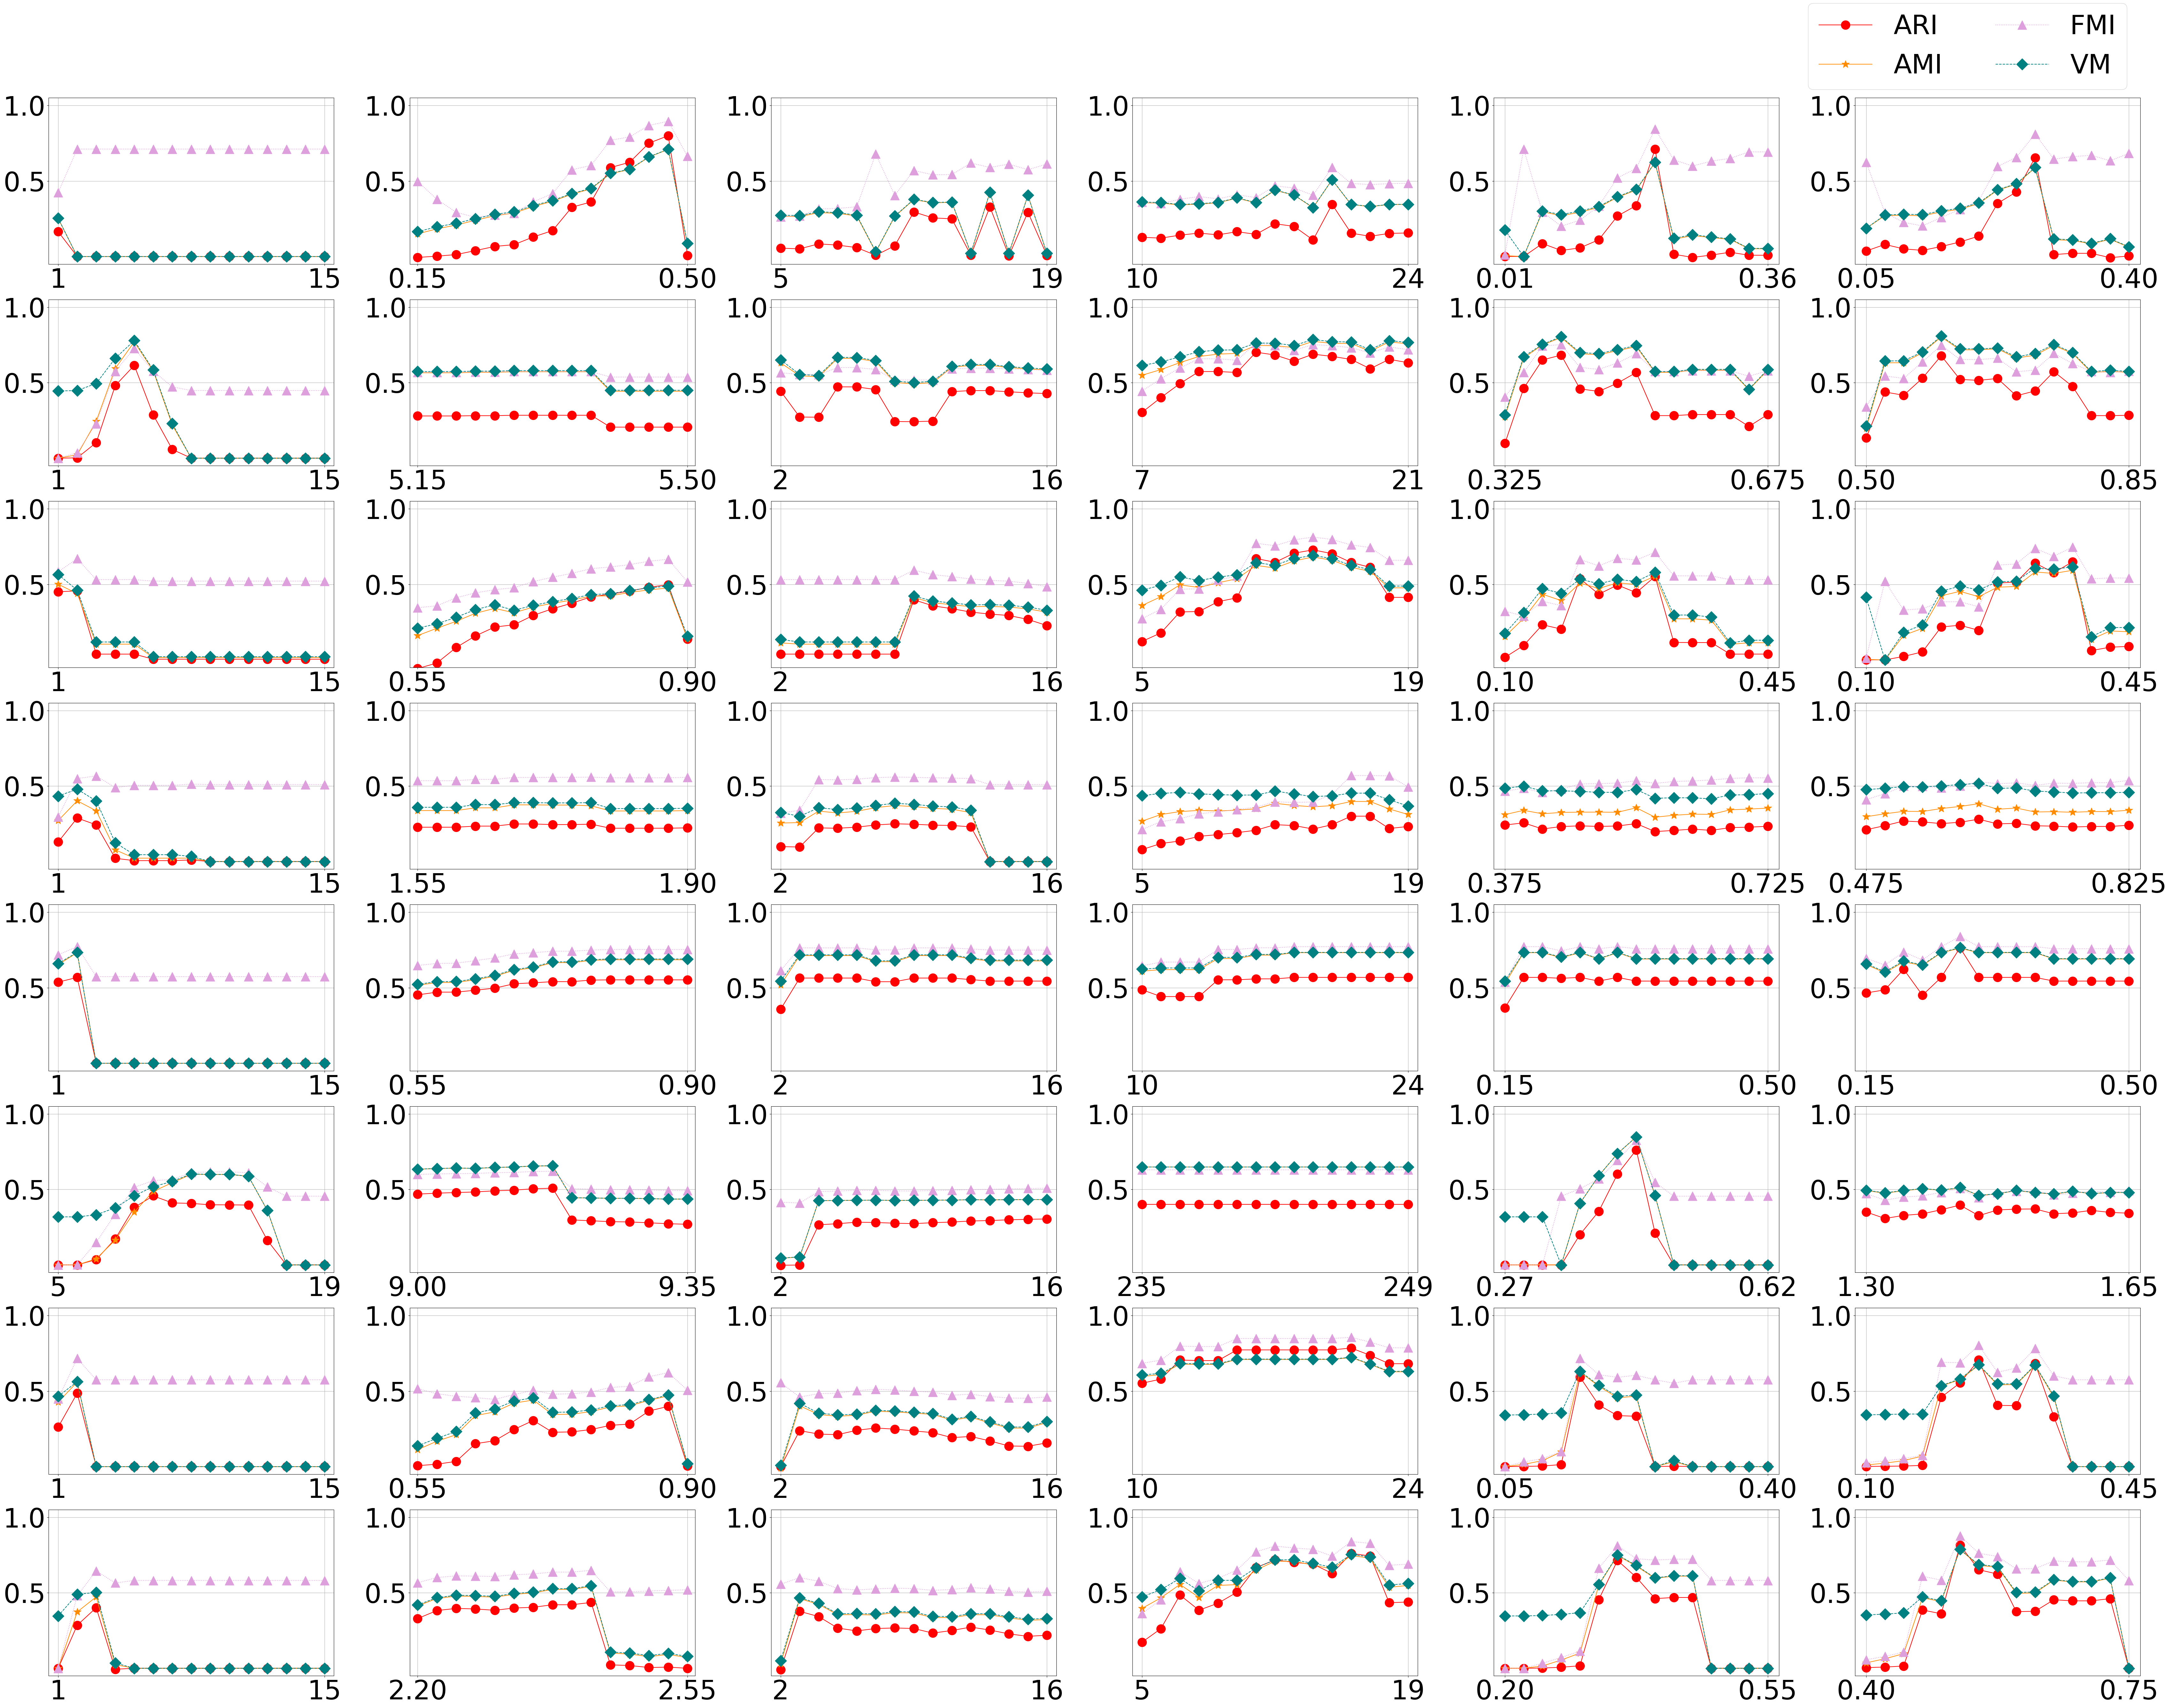

In [5]:
visualize_params_global()

In [5]:
compare_best_params()